设置HOME

In [9]:
import os
HOME = os.getcwd()
print(HOME)



d:\workspaces\yolov8train


检查YOLOV8

In [10]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.73  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Setup complete  (20 CPUs, 63.7 GB RAM, 165.4/274.7 GB disk)


In [11]:
!mkdir {HOME}/datasets
# %cd {HOME}/datasets

d:\workspaces\yolov8train\datasets


�����﷨����ȷ��


In [11]:
import shutil
import os

# 获取当前脚本的目录
# current_dir = os.path.dirname(os.path.abspath(__file__))

# 构建相对路径
# cache_dir = os.path.join(current_dir, "runs")
cache_dir = os.path.join(f'{HOME}', "runs")

# 检查目录是否存在
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print(f"缓存目录 {cache_dir} 已删除。")
else:
    print(f"缓存目录 {cache_dir} 不存在。")


缓存目录 d:\workspaces\yolov8train\runs 不存在。


原始图片目录一般放在某个D盘和项目无关目录下，也可以放在项目目录下。使用x anylabeling标记后的图片，自带一个json文件。训练yolo模块的时候，需要转换一下。

In [12]:
import shutil
import os

# 获取当前脚本的目录
# current_dir = os.path.dirname(os.path.abspath(__file__))

# 构建相对路径
# cache_dir = os.path.join(current_dir, "runs")
cache_dir = os.path.join(f'{HOME}', "datasets", "OCR")

# 检查目录是否存在
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print(f"OCR目录 {cache_dir} 已删除。")
else:
    print(f"OCR目录 {cache_dir} 不存在。")

OCR目录 d:\workspaces\yolov8train\datasets\OCR 已删除。


In [13]:
import os
import json
import random
import shutil

def process_files(input_dir, files, split):
    for filename in files:
        with open(os.path.join(input_dir, filename)) as f:
            data = json.load(f)

        # Create corresponding image and label paths
        image_filename = data['imagePath']  # Assuming the images are .jpg
        label_filename = filename.replace('.json', '.txt')

        image_output_path = os.path.join(output_dir, 'images', split, image_filename)
        label_output_path = os.path.join(output_dir, 'labels', split, label_filename)

        # Copy the image to the output directory
        shutil.copy(os.path.join(input_dir, image_filename), image_output_path)

        with open(label_output_path, 'w') as out_file:
            for shape in data['shapes']:
                if shape['shape_type'] == 'circle':
                    # For circles, points contain the center and a point on the circumference
                    x_center, y_center = shape['points'][0]
                    x_circum, y_circum = shape['points'][1]

                    radius = ((x_center - x_circum) ** 2 + (y_center - y_circum) ** 2) ** 0.5
                    x1 = x_center - radius
                    y1 = y_center - radius
                    x2 = x_center + radius
                    y2 = y_center + radius
                else:
                    # For other shapes, we'll assume it's a rectangle for simplicity
                    x1, y1 = shape['points'][0]
                    x2, y2 = shape['points'][2]

                dw = 1. / data['imageWidth']
                dh = 1. / data['imageHeight']
                w = x2 - x1
                h = y2 - y1
                x = x1 + (w / 2)
                y = y1 + (h / 2)

                x *= dw
                w *= dw
                y *= dh
                h *= dh

                class_label = class_labels[shape['label']]

                out_file.write(f"{class_label} {x} {y} {w} {h}\n")

# Define the class labels 
class_labels = {"W2": 0, "E1": 1, "M1": 2, "W1": 3} # Change/add more for your database

# Define the directories
# input_dir = 'D:/workspaces/photos_bak/OCRs/W2' # Replace with your directory
# input_dir = 'D:/workspaces/photos_bak/OCRs/M1' # Replace with your directory
# input_dir = 'D:/workspaces/photos_bak/OCRs/W1' # Replace with your directory
# input_dir = 'D:/workspaces/photos_bak/OCRs/E1' # Replace with your directory

output_dir = './datasets/OCR' # Replace with your directory
os.makedirs(output_dir, exist_ok=True)

# Create the output directories
os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)

input_dir_home = 'D:/workspaces/photos_bak/OCRs'
input_dirs = [f for f in os.listdir(input_dir_home) if os.path.isdir(os.path.join(input_dir_home, f))]

for _input_dir in input_dirs:
    # Collect all json filenames
    json_files = [f for f in os.listdir(os.path.join(input_dir_home, _input_dir)) if f.endswith('.json')]

    # Define the split ratio
    split_ratio = 0.9

    # Shuffle and split the files
    random.shuffle(json_files)
    split_index = int(len(json_files) * split_ratio)
    train_files = json_files[:split_index]
    val_files = json_files[split_index:]

    # Process the files
    process_files(os.path.join(input_dir_home, _input_dir), train_files, 'train')
    process_files(os.path.join(input_dir_home, _input_dir), val_files, 'val')


print("Conversion and splitting completed successfully!")


Conversion and splitting completed successfully!


检查 CUDA


In [15]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
torch.cuda.empty_cache()


print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.backends.cudnn.version())
print(torch.version.cuda)

CUDA available: True
CUDA device count: 1


命令行训练（这个方式训练，看不到控制台输出，只能等全部结束后，显示结果）

```shell
yolo task=detect mode=train model=yolov8s.pt data=textdataset.yaml epochs=25 imgsz=800 plots=True


# yolo task=detect mode=train model=yolov8l.pt data=textdataset.yaml epochs=50 imgsz=928   配置低，跑不动
yolo task=detect mode=train model=yolov8m.pt data=textdataset.yaml epochs=50 imgsz=928 
# yolo task=detect mode=train model=W2.pt data=textdataset.yaml epochs=50 imgsz=928 
# yolo task=detect mode=train model=W2M1.pt data=textdataset.yaml epochs=50 imgsz=928 
yolo task=detect mode=train model=W2M1W1.pt data=textdataset.yaml epochs=50 imgsz=928 
# yolo task=detect mode=train model=yolov8s.pt data=textdataset.yaml epochs=50 imgsz=928 
```

In [21]:
%cd {HOME}

d:\workspaces\yolov8train


In [23]:

!yolo task=detect mode=train model=yolov8s.pt data={HOME}/textdataset.yaml epochs=25 imgsz=800 plots=True

New https://pypi.org/project/ultralytics/8.2.79 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.73 🚀 Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=d:\workspaces\yolov8train/textdataset.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fals

C:\Users\07781\AppData\Local\anaconda3\envs\yolo\Lib\site-packages\ultralytics\engine\trainer.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)

train: Scanning D:\workspaces\yolov8train\datasets\OCR\labels\train...:   0%|          | 0/100 [00:00<?, ?it/s]
train: Scanning D:\workspaces\yolov8train\datasets\OCR\labels\train... 31 images, 0 backgrounds, 0 corrupt:  31%|███       | 31/100 [00:00<00:00, 308.18it/s]
train: Scanning D:\workspaces\yolov8train\datasets\OCR\labels\train... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 685.75it/s]

val: Scanning D:\workspaces\yolov8train\datasets\OCR\labels\val...:   0%|          | 0/12 [00:00<?, ?it/s]
val: Scanning D:\workspaces\yolov8train\datasets\OCR\labels\val... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<00:00, 562.20it/s]

  0%|          | 0

In [8]:
from ultralytics import YOLO

from IPython.display import display, Image

In [9]:
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\workspaces\\yolov8train/runs/detect/train/confusion_matrix.png'

d:\workspaces\yolov8train


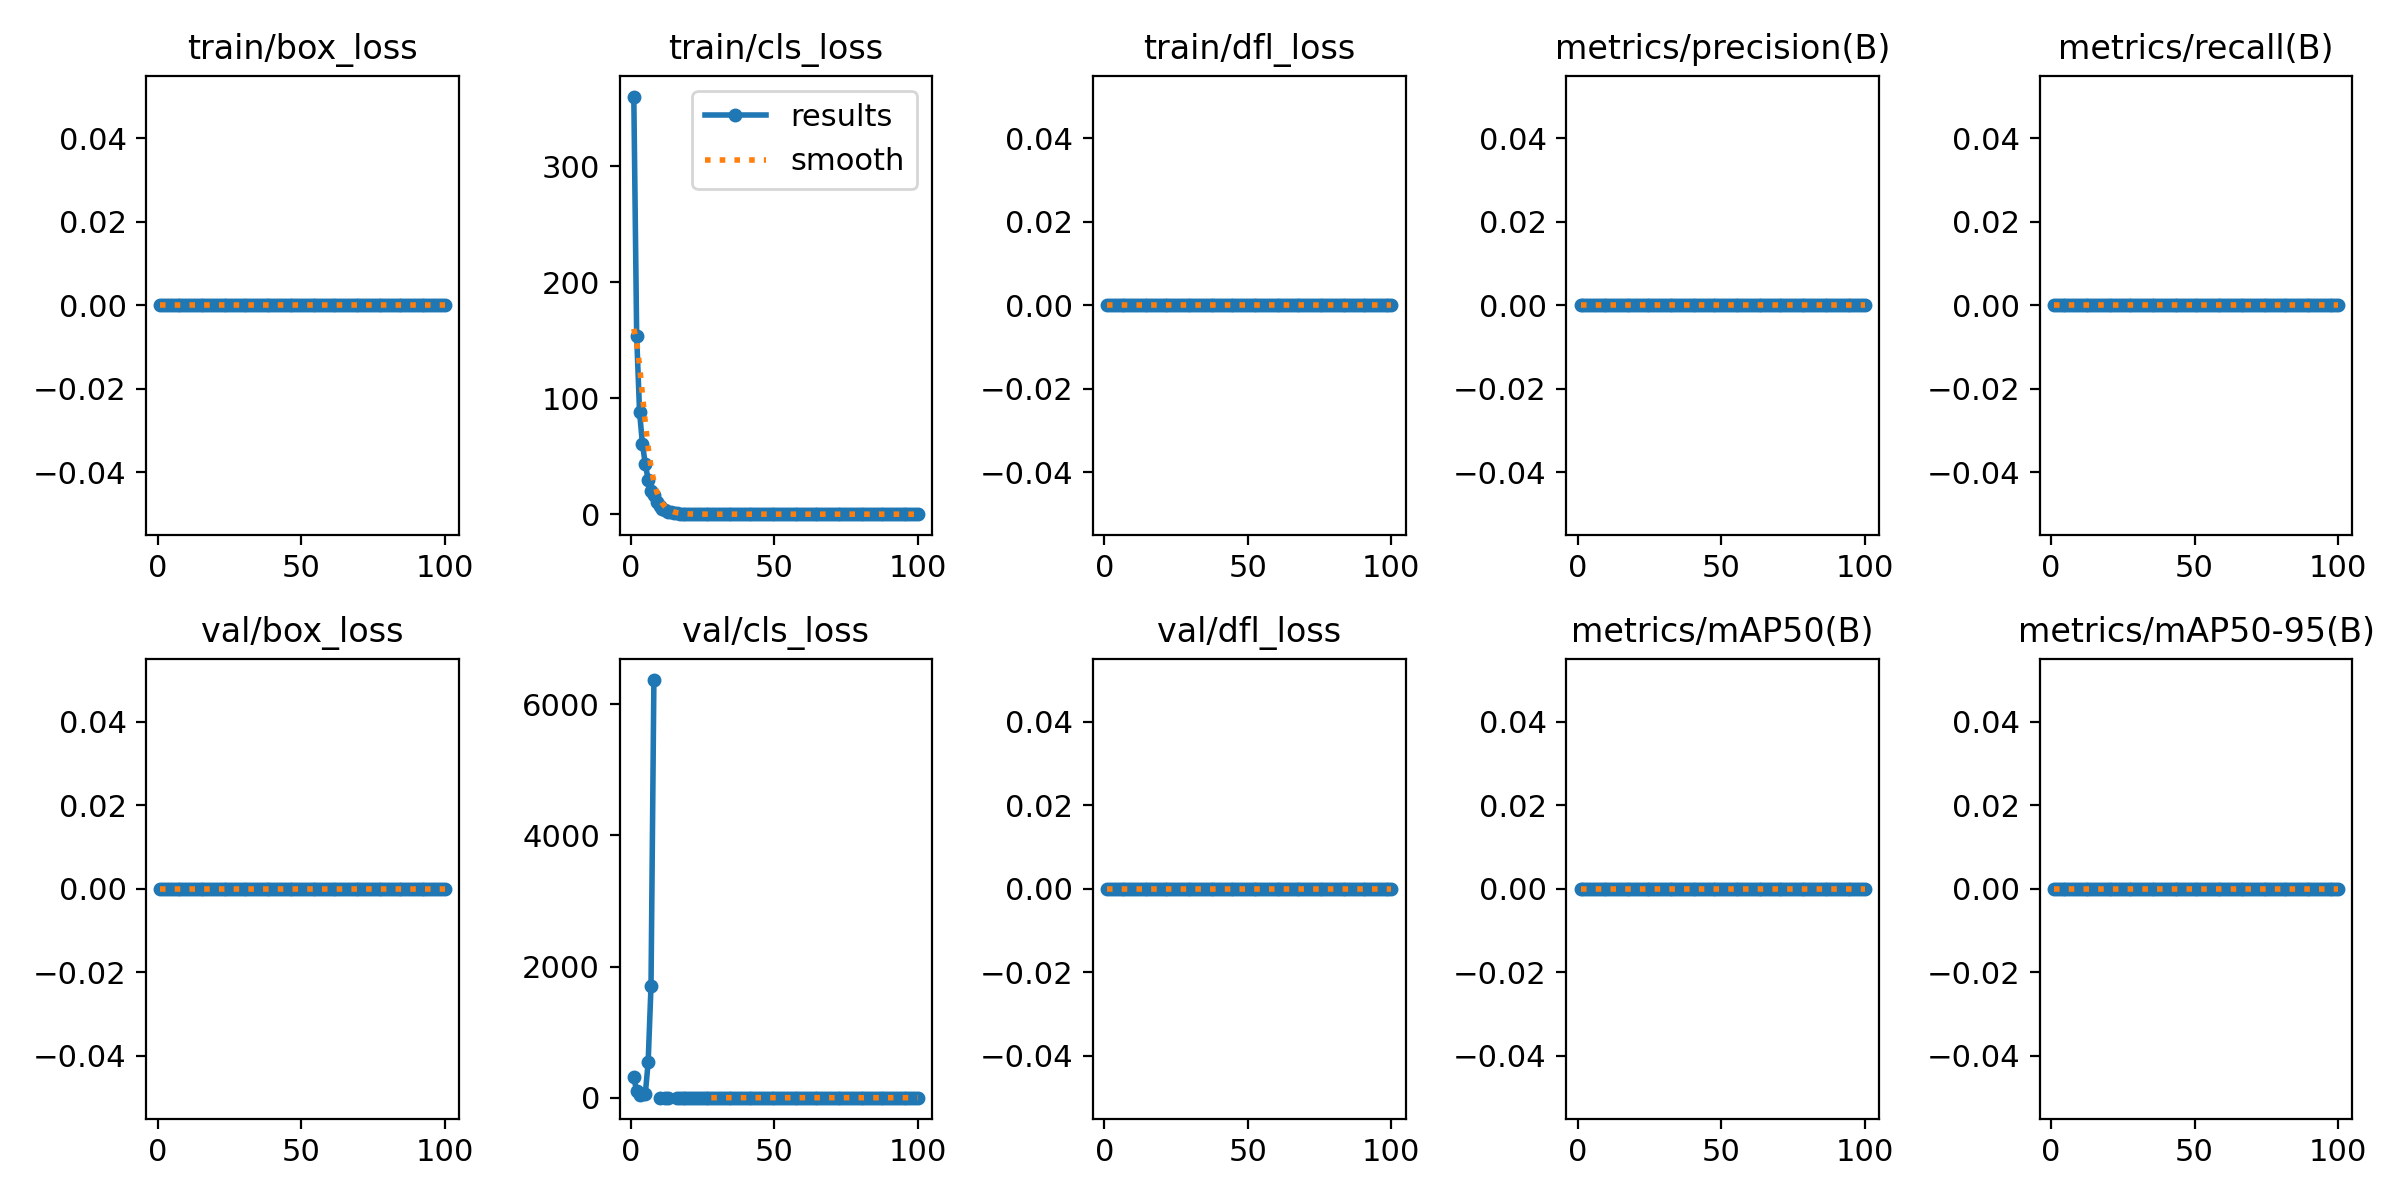

In [7]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

d:\workspaces\yolov8train


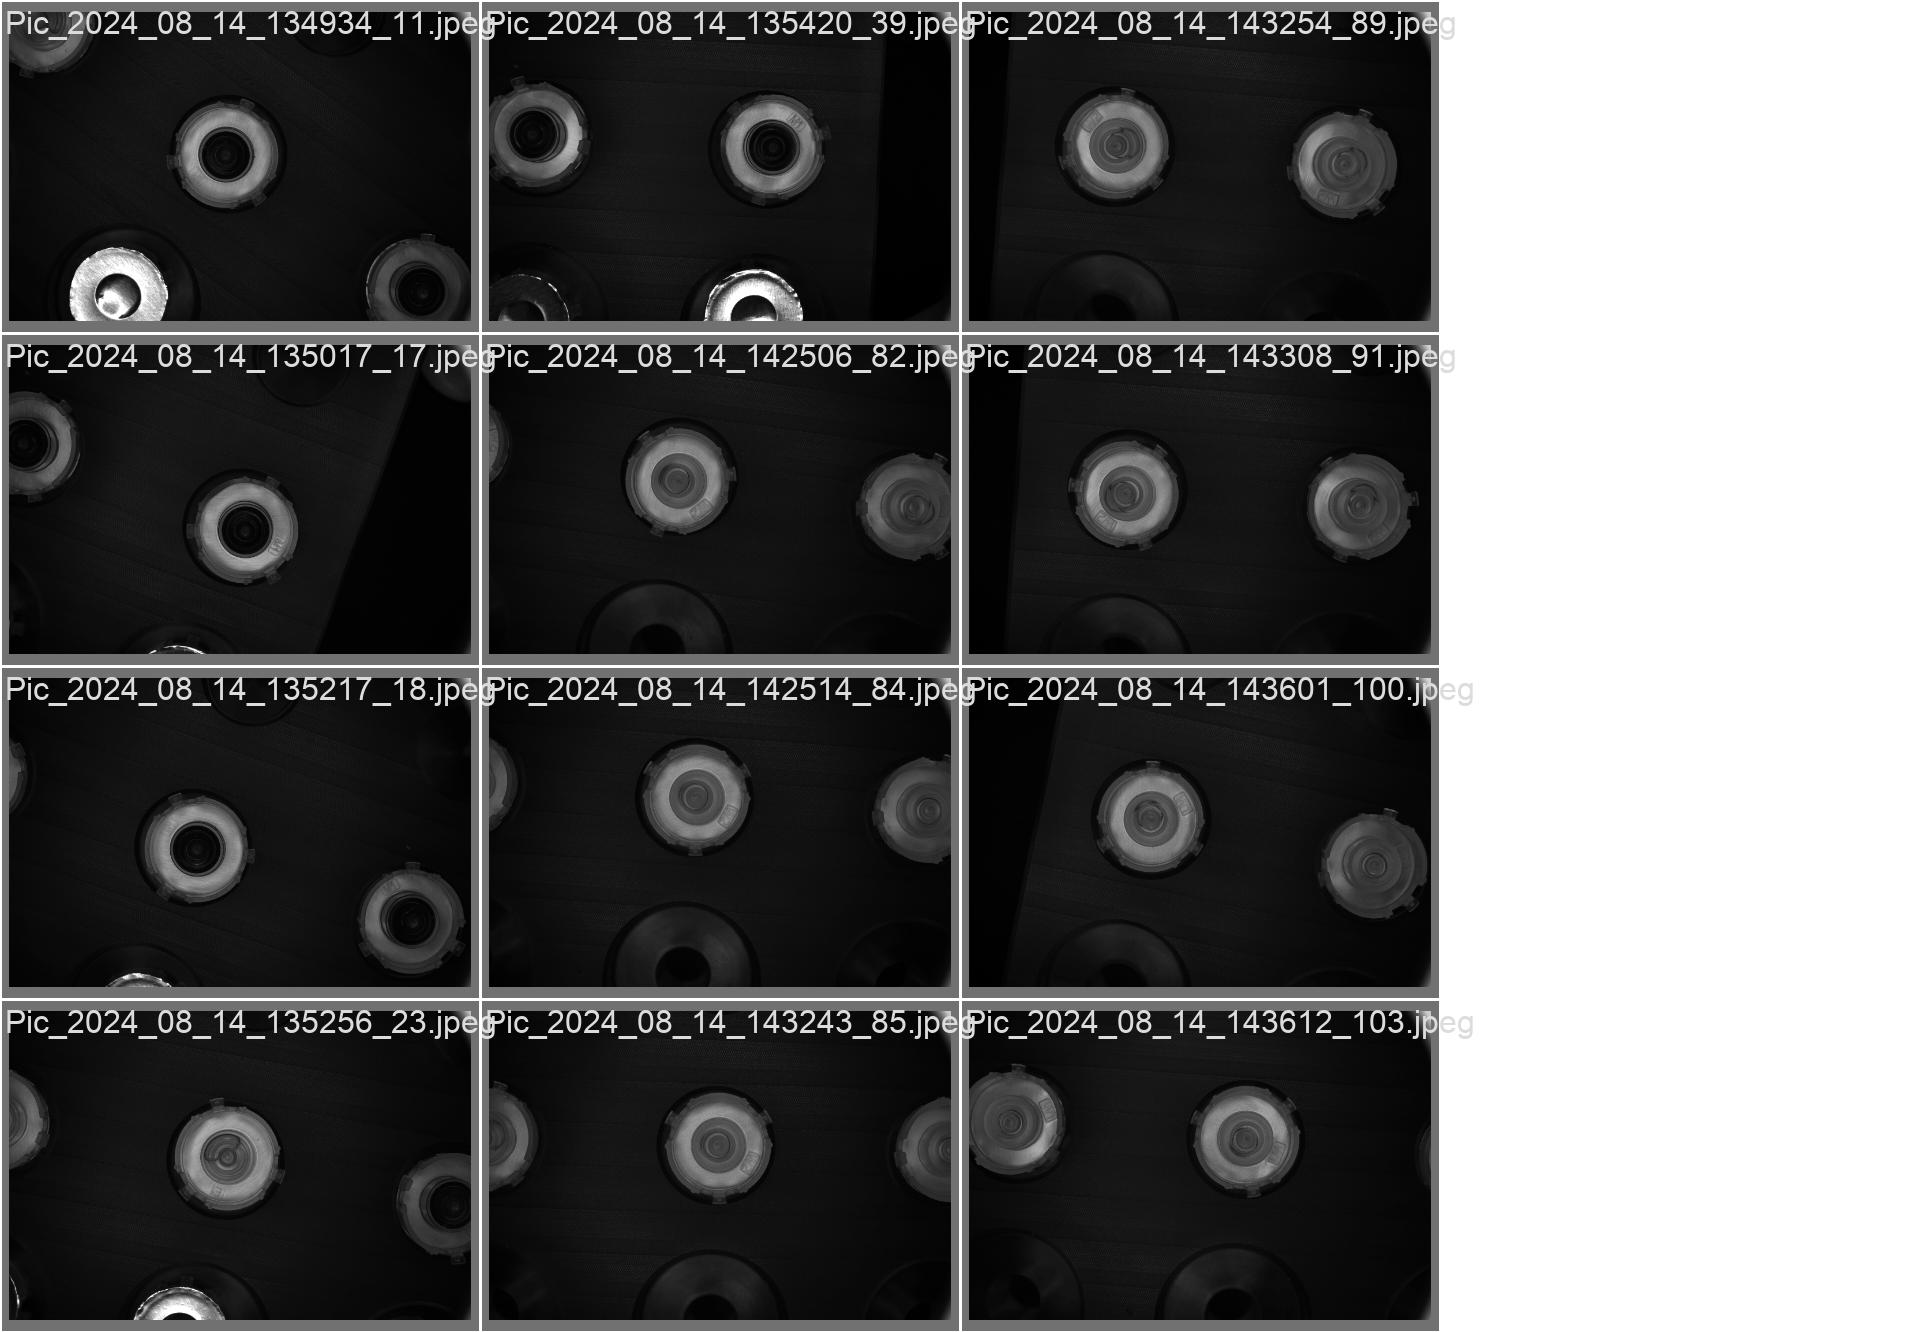

In [8]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [9]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data=textdataset.yaml

d:\workspaces\yolov8train
Ultralytics YOLOv8.2.73 🚀 Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients
                   all         12         21          0          0          0          0
Speed: 0.5ms preprocess, 11.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\val
💡 Learn more at https://docs.ultralytics.com/modes/val



val: Scanning D:\workspaces\yolov8train\datasets\OCR\labels\val.cache... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<?, ?it/s]
val: Scanning D:\workspaces\yolov8train\datasets\OCR\labels\val.cache... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]


## Inference with Custom Model

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

In [14]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={HOME}/pictures save=True

Ultralytics YOLOv8.2.73 🚀 Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients

image 1/43 d:\workspaces\yolov8train\pictures\NG_NG_1.jpg: 704x928 2 W2s, 1 W1, 48.4ms
image 2/43 d:\workspaces\yolov8train\pictures\NG_NG_10.jpg: 704x928 2 W2s, 2 W1s, 27.3ms
image 3/43 d:\workspaces\yolov8train\pictures\NG_NG_11.jpg: 704x928 4 W2s, 1 W1, 26.2ms
image 4/43 d:\workspaces\yolov8train\pictures\NG_NG_12.jpg: 704x928 2 W2s, 3 W1s, 26.8ms
image 5/43 d:\workspaces\yolov8train\pictures\NG_NG_13.jpg: 704x928 4 W2s, 2 W1s, 26.2ms
image 6/43 d:\workspaces\yolov8train\pictures\NG_NG_14.jpg: 704x928 1 W2, 2 W1s, 27.0ms
image 7/43 d:\workspaces\yolov8train\pictures\NG_NG_15.jpg: 704x928 3 W2s, 2 W1s, 27.7ms
image 8/43 d:\workspaces\yolov8train\pictures\NG_NG_16.jpg: 704x928 2 W2s, 2 W1s, 27.6ms
image 9/43 d:\workspaces\yolov8train\pictures\NG_NG_17.jpg: 704x928 2 W2s, 1 M1, 25.7ms
image 10/43 d:\workspaces\yo

旧的 detect all python 脚本：

In [17]:
import cv2
import math
import os

from ultralytics import YOLO

def detect_one(model, img_path, output_path):
    # 读取要检测的图片
    img = cv2.imread(img_path)

        # 使用模型进行检测
    results = model(img)

    # 提取检测结果
    for result in results:
        boxes = result.boxes  # 检测到的边界框
        for box in boxes:
            # 调试信息，查看 box.xyxy 的实际内容和类型
            print(f'box.xyxy type: {type(box.xyxy)}')
            print(f'box.xyxy content: {box.xyxy}')

            # 将边界框坐标转换为列表，然后解包为四个标量值
            # coords = box.xyxy[0].tolist() if hasattr(box.xyxy, 'tolist') else box.xyxy
            # x1, y1, x2, y2 = map(int, coords)  # 边界框坐标
            # # x1, y1, x2, y2 = map(int, box.xyxy.tolist())  # 边界框坐标
            # conf = box.conf  # 置信度
            # cls = box.cls  # 类别


            # 将边界框坐标转换为列表，然后解包为四个标量值
            coords = box.xyxy[0].tolist() if hasattr(box.xyxy, 'tolist') else box.xyxy[0]
            x1, y1, x2, y2 = map(int, coords)  # 边界框坐标
            conf = float(box.conf[0].item())  # 置信度，转换为标量
            cls = int(box.cls[0].item())  # 类别，转换为标量

            # 获取类别名称
            class_name = result.names[cls]

            # 计算圆心和半径
            # center_x = (x1 + x2) // 2
            # center_y = (y1 + y2) // 2
            # radius = min((x2 - x1) // 2, (y2 - y1) // 2)

            # # 在图像上画圆
            # cv2.circle(img, (center_x, center_y), radius, (0, 255, 0), 2)


            # 计算圆心和半径
            center_x = x1
            center_y = y1
            # radius = int(math.sqrt((x2 - x1)**2 + (y2 - y1)**2) / 2)
            radius = int(math.sqrt((x2 - x1)**2 + (y2 - y1)**2) )
            # 在图像上画圆
            cv2.circle(img, (center_x, center_y), radius, (0, 255, 0), 2)
            
            # 绘制置信度和类别
            # label = f'Class: {cls}, Conf: {conf:.2f}'
            # label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            # label_x = x1
            # label_y = y1 - 10 if y1 - 10 > 10 else y1 + 10
            # cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
            
            
            # 绘制置信度和类别
            label = f'{class_name}: {conf:.2f}'
            font_scale = 6  # 字体大小
            thickness = 16  # 字体粗细
            label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
            label_x = x1 - radius + 10
            label_y = y1 - 10 if y1 - 10 > 10 else y1 + 10
            cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 0), thickness)
            
            # 打印检测结果
            print(f"Class: {cls}, Confidence: {conf}, Center: ({center_x}, {center_y}), Radius: {radius}")

    # 保存带有圆形标记的图片
    cv2.imwrite(output_path, img)
    print(f"Marked image saved at {output_path}")

if __name__ == '__main__':
    # 加载训练好的 YOLOv8 模型
    model = YOLO('W2M1W1E1.pt')

    HOME = os.getcwd()
    image_path = os.path.join(HOME, 'pictures')

    # all file under image_path
    files = os.listdir(image_path)

    # detect all images
    for file in files:
        print(file)

        if file.endswith('.jpg'):
            img_path = os.path.join(image_path, file)
            output_path = os.path.join(image_path, file.replace('.jpg', '_marked.jpg'))
            detect_one(model, img_path, output_path)

        # if file.endswith('.jpeg'):
        #     img_path = os.path.join(image_path, file)
        #     output_path = os.path.join(image_path, file.replace('.jpeg', '_marked.jpeg'))
        #     detect_one(model, img_path, output_path)

        # delete all files end with _marked.jpg
        # if file.endswith('_marked.jpg') or file.endswith('_marked.jpeg'):
        #     os.remove(os.path.join(image_path, file))


NG_NG_1.jpg

0: 704x928 2 E1s, 48.4ms
Speed: 5.7ms preprocess, 48.4ms inference, 63.3ms postprocess per image at shape (1, 3, 704, 928)
box.xyxy type: <class 'torch.Tensor'>
box.xyxy content: tensor([[1579.8464,  775.3710, 1718.1624, 1010.9025]], device='cuda:0')
Class: 1, Confidence: 0.9519256949424744, Center: (1579, 775), Radius: 273
box.xyxy type: <class 'torch.Tensor'>
box.xyxy content: tensor([[  64.7283,  979.0070,  285.5551, 1190.6030]], device='cuda:0')
Class: 1, Confidence: 0.8136628866195679, Center: (64, 979), Radius: 305
Marked image saved at d:\workspaces\yolov8train\pictures\NG_NG_1_marked.jpg
NG_NG_10.jpg

0: 704x928 2 E1s, 26.9ms
Speed: 4.0ms preprocess, 26.9ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 928)
box.xyxy type: <class 'torch.Tensor'>
box.xyxy content: tensor([[1554.6498,  842.1055, 1726.9712, 1075.1089]], device='cuda:0')
Class: 1, Confidence: 0.9310754537582397, Center: (1554, 842), Radius: 289
box.xyxy type: <class 'torch.Tensor'>
box.xyx

## Export the model to ONNX format

In [15]:
!yolo export model=allOcr.pt format=onnx

Ultralytics YOLOv8.2.73 🚀 Python-3.12.4 torch-2.4.0 CPU (12th Gen Intel Core(TM) i9-12900H)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients

PyTorch: starting from 'allOcr.pt' with input shape (1, 3, 928, 928) BCHW and output shape(s) (1, 8, 17661) (49.7 MB)

ONNX: starting export with onnx 1.16.2 opset 19...
ONNX: export success ✅ 1.8s, saved as 'allOcr.onnx' (99.0 MB)

Export complete (6.1s)
Results saved to D:\workspaces\yolov8train
Predict:         yolo predict task=detect model=allOcr.onnx imgsz=928  
Validate:        yolo val task=detect model=allOcr.onnx imgsz=928 data=textdataset.yaml  
Visualize:       https://netron.app
💡 Learn more at https://docs.ultralytics.com/modes/export


In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO("q_x_filter_1.pt")

# Export the model to ONNX format
model.export(format="onnx")  # creates 'q1.onnx'